## Basic CNN fronted LSTM classifier
Have overfitting, didn't optimise

In [4]:
 # an optimiser version is available below
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        shear=5,
        scale=(0.8, 1.2)
    ),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])
bs = 512
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=2)



class RecurrentBlock(nn.Module):
    def __init__(self):
        super(RecurrentBlock, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm = nn.LSTM(7200, 1024, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(1024, 2048)
        self.fc2 = nn.Linear(2048, 10)
    
    def forward(self, x):
        bs = x.size(0)
        out = F.elu(self.conv1(x))
        out = F.elu(self.conv2(out))
        out = self.pool1(out)
        out = self.dropout1(out)
        out  = out.view(bs,1, -1)

        out, _ = self.lstm(out)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = RecurrentBlock().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
epochs_recorded = []

# Training
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    avg_train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct_train / total_train
    print(f'Epoch {epoch+1}, Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')

    # Evaluation every 5 epochs
    if (epoch+1) % 5 == 0 and epoch > 1:
        model.eval()

        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_test_loss = test_loss / len(testloader)
        test_acc = 100 * correct / total
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
        
        # Store metrics
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        epochs_recorded.append(epoch + 1)

# Plot graphs
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs_recorded, train_losses, 'b-', marker='o', label='Train')
plt.plot(epochs_recorded, test_losses, 'r-', marker='s', label='Test')
plt.title('Train vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Combined accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs_recorded, train_accuracies, 'g-', marker='o', label='Train')
plt.plot(epochs_recorded, test_accuracies, 'r-', marker='s', label='Test')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Using device: cuda


KeyboardInterrupt: 

Accuracy: 64.63%
Epoch 42, Loss: 0.3226
Epoch 43, Loss: 0.2490
Epoch 44, Loss: 0.2770
Epoch 45, Loss: 0.2752
Epoch 46, Loss: 0.3371
Accuracy: 64.41%
Epoch 47, Loss: 0.2480
Epoch 48, Loss: 0.2738
Epoch 49, Loss: 0.2071
Epoch 50, Loss: 0.1946

## One Step gradient
I dont see the big time advantage here


Using device: cuda
Epoch 1, Loss: 1.5328, Train Accuracy: 44.97%
Epoch 2, Loss: 1.2340, Train Accuracy: 55.69%
Epoch 3, Loss: 1.1226, Train Accuracy: 60.30%
Epoch 4, Loss: 1.0446, Train Accuracy: 63.22%
Epoch 5, Loss: 0.9984, Train Accuracy: 64.67%
Test Loss: 0.8867, Test Accuracy: 69.30%
Epoch 6, Loss: 0.9495, Train Accuracy: 66.43%
Epoch 7, Loss: 0.9136, Train Accuracy: 68.02%
Epoch 8, Loss: 0.8825, Train Accuracy: 68.84%
Epoch 9, Loss: 0.8545, Train Accuracy: 69.86%
Epoch 10, Loss: 0.8296, Train Accuracy: 70.84%
Test Loss: 0.7788, Test Accuracy: 73.00%


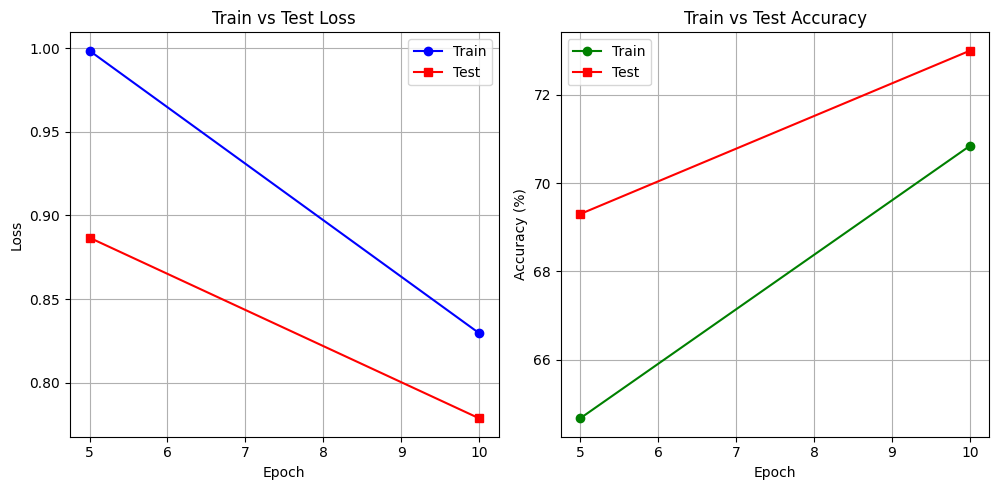

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        shear=5,
        scale=(0.8, 1.2)
    ),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])
bs = 512
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=2)

class RecurrentBlock(nn.Module):
    def __init__(self):
        super(RecurrentBlock, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        
        # Calculate LSTM input size based on conv output
        # After conv1 (3->16, kernel=3): 32-2=30
        # After conv2 (16->32, kernel=3): 30-2=28  
        # After maxpool with padding: 28+2=30, then 30//2=15
        # So LSTM input size: 32 * 15 * 15 = 7200
        self.lstm_input_size = 7200
        self.lstm_hidden_size = 1024
        
        self.lstm = nn.LSTM(self.lstm_input_size, self.lstm_hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.lstm_hidden_size, 2048)
        self.fc2 = nn.Linear(2048, 10)
    
    def forward(self, x):
        bs = x.size(0)
        out = F.elu(self.conv1(x))
        out = F.elu(self.conv2(out))
        out = self.pool1(out)
        out = self.dropout1(out)
        out = out.view(bs, 1, -1)  # Reshape for LSTM: (batch, seq_len=1, features)

        if self.training:
            # For training: use 1-step gradient update (truncated BPTT K=1)
            # Since we only have 1 timestep here, we just run normally but could extend this
            # for multi-step sequences by running first T-1 steps with no_grad
            out, _ = self.lstm(out)
        else:
            # In eval, run normally
            out, _ = self.lstm(out)
            
        out = self.dropout2(out)
        out = self.fc1(out[:, -1, :])  # Use last (and only) timestep
        out = self.fc2(out)
        return out

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = RecurrentBlock().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
epochs_recorded = []

# Training
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    avg_train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct_train / total_train
    print(f'Epoch {epoch+1}, Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')

    # Evaluation every 5 epochs
    if (epoch+1) % 5 == 0 and epoch > 1:
        model.eval()

        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_test_loss = test_loss / len(testloader)
        test_acc = 100 * correct / total
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
        
        # Store metrics
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        epochs_recorded.append(epoch + 1)

# Plot graphs
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs_recorded, train_losses, 'b-', marker='o', label='Train')
plt.plot(epochs_recorded, test_losses, 'r-', marker='s', label='Test')
plt.title('Train vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Combined accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs_recorded, train_accuracies, 'g-', marker='o', label='Train')
plt.plot(epochs_recorded, test_accuracies, 'r-', marker='s', label='Test')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Testing profiler


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.profiler

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        shear=5,
        scale=(0.8, 1.2)
    ),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)

# RNN Model
class RecurrentBlock(nn.Module):
    def __init__(self):
        super(RecurrentBlock, self).__init__()
        self.hidden_size = 128 * 8  # 1024
        self.input_size = 96        # 3 * 32
        self.seq_len = 32

        self.rnn = nn.LSTM(self.input_size, self.hidden_size, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 10)
    
    def forward(self, x):
        b = x.size(0)
        x = x.view(b, self.seq_len, self.input_size)

        if self.training:
            # First T-1 steps without tracking gradients
            with torch.no_grad():
                _, (h, c) = self.rnn(x[:, :-1, :])  # shapes: (num_layers, B, H)
            # Last step with gradients, starting from detached hidden state
            h = h.detach()
            c = c.detach()
            out_last, _ = self.rnn(x[:, -1:, :], (h, c))  # shape: (B, 1, H)
        else:
            # In eval, just run normally
            out_last, _ = self.rnn(x)  # (B, T, H)

        logits = self.fc(out_last[:, -1, :])  # use last timestep
        return logits

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = RecurrentBlock().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training with profiler
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./profiler_logs'),
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
    model.train()
    for epoch in range(2):
        for step, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            prof.step()
            if step >= 10:
                break
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# Print profiling results
print("\nTop 20 operations by CUDA time:")
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))
print("\nTop 20 operations by CPU time:")
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

# Continue regular training
for epoch in range(2, 5):
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Using device: cuda
Epoch 1, Loss: 2.1809
Epoch 2, Loss: 2.0637

Top 20 operations by CUDA time:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         0.00%       0.000us         0.00%       0.000us       0.000us      64.605ms 

another test i've tried. gets decent accuracy


Using device: cuda
Epoch 1, Loss: 1.4675, Train Accuracy: 47.09%
Epoch 2, Loss: 1.1310, Train Accuracy: 59.74%
Epoch 3, Loss: 1.0026, Train Accuracy: 64.57%
Epoch 4, Loss: 0.9191, Train Accuracy: 67.64%
Epoch 5, Loss: 0.8604, Train Accuracy: 69.75%
Test Loss: 0.8390, Test Accuracy: 70.66%
Epoch 6, Loss: 0.8045, Train Accuracy: 71.67%
Epoch 7, Loss: 0.7632, Train Accuracy: 73.04%
Epoch 8, Loss: 0.7255, Train Accuracy: 74.62%
Epoch 9, Loss: 0.6944, Train Accuracy: 75.70%
Epoch 10, Loss: 0.6667, Train Accuracy: 76.61%
Test Loss: 0.7650, Test Accuracy: 74.24%


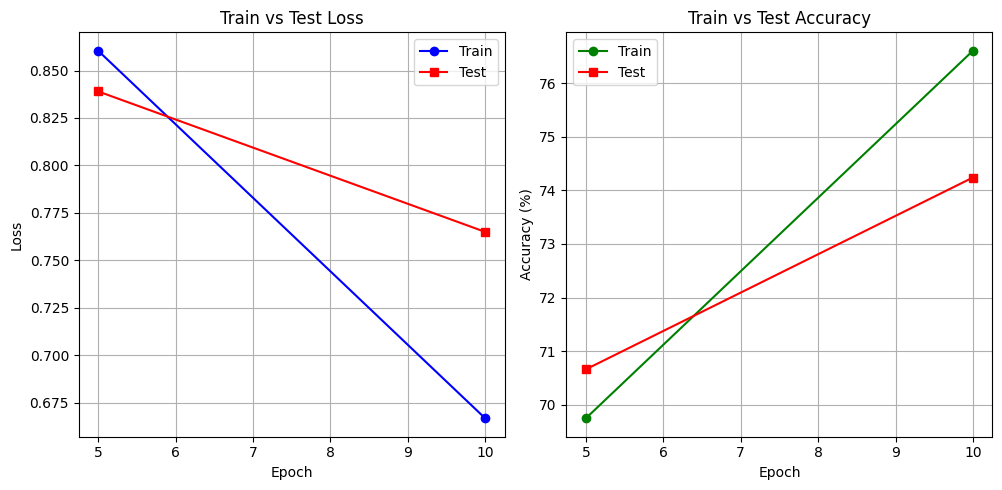

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        shear=5,
        scale=(0.8, 1.2)
    ),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])
bs = 512
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=2)

class HighBlock(nn.Module):
    '''
    High level CEO planner; slow
    '''
    def __init__(self):
        super(HighBlock, self).__init__()

class LowBlock(nn.Module):
    '''
    Low level worker; super fast
    '''
    def __init__(self):
        super(LowBlock, self).__init__()

class HRM(nn.Module):
    def __init__(self):
        super(HRM, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        
        self.lstm = nn.LSTM(7200, 1024, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(1024, 2048)
        self.fc2 = nn.Linear(2048, 10)
    
    def forward(self, x):
        bs = x.size(0)
        out = F.elu(self.conv1(x))
        out = F.elu(self.conv2(out))
        out = self.pool1(out)
        out = self.dropout1(out)
        out  = out.view(bs,1, -1)

        out, _ = self.lstm(out)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

# class RecurrentBlock(nn.Module):
#     def __init__(self):
#         super(RecurrentBlock, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3)
#         self.conv2 = nn.Conv2d(16, 32, 3)
#         self.pool1 = nn.MaxPool2d(2, 2, padding=1)
#         self.dropout1 = nn.Dropout(0.5)
#         self.lstm = nn.LSTM(7200, 1024, batch_first=True)
#         self.dropout1 = nn.Dropout(0.3)
#         self.fc1 = nn.Linear(1024, 2048)
#         self.fc2 = nn.Linear(2048, 10)
    
#     def forward(self, x):
#         bs = x.size(0)
#         out = F.elu(self.conv1(x))
#         out = F.elu(self.conv2(out))
#         out = self.pool1(out)
#         out = self.dropout1(out)
#         out  = out.view(bs,1, -1)

#         out, _ = self.lstm(out)
#         out = self.fc1(out[:, -1, :])
#         out = self.fc2(out)
#         return out

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = HRM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
epochs_recorded = []

# Training
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    avg_train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct_train / total_train
    print(f'Epoch {epoch+1}, Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')

    # Evaluation every 5 epochs
    if (epoch+1) % 5 == 0 and epoch > 1:
        model.eval()

        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_test_loss = test_loss / len(testloader)
        test_acc = 100 * correct / total
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
        
        # Store metrics
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        epochs_recorded.append(epoch + 1)

# Plot graphs
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs_recorded, train_losses, 'b-', marker='o', label='Train')
plt.plot(epochs_recorded, test_losses, 'r-', marker='s', label='Test')
plt.title('Train vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Combined accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs_recorded, train_accuracies, 'g-', marker='o', label='Train')
plt.plot(epochs_recorded, test_accuracies, 'r-', marker='s', label='Test')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()